# Info

The whole code can be ran pretty simply:

First, play the hidden code on "Load essential tools & initiate network settings" - this uploads all necessary libraries and custom functions etc.

Then, import data below.

Next, just set up the fitted model, seed, index etc. and just run the "Model" part.

In [ ]:
### IMPORT DATA ###
uploaded_data = files.upload()

# Load essential tools & initiate network settings

In [ ]:
#@title
########## IMPORT NECESSARY LIBRARIES ##########

!pip install -q pandas_ta
!pip install -q keras-tuner

import os, io, locale, random, sys, time
import numpy as np
import pandas as pd
import seaborn as sb
import keras_tuner
import pandas_ta as ta
import tensorflow as tf
import keras.backend as K
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas_datareader as data
import matplotlib.dates as mdates

from tensorflow import keras
from keras import layers
from functools import reduce
from numpy.random import seed
from google.colab import files
from itertools import accumulate
from keras_tuner import RandomSearch
from IPython.display import display, HTML
from tensorflow.keras.models import Sequential
from datetime import date, datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, log_loss, f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score, log_loss


########## CUSTOM FUNCTIONS ##########

#### Hellinger distance for attention visualization ####
def hellinger(h1, h2):

  def normalize(h):
    return h / np.sum(h)

  return np.sqrt(1 - np.sum(np.sqrt(np.multiply(normalize(h1), normalize(h2)))))


#### Time2Vec implementation ####
class Time2Vec(layers.Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vec, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
  
  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'seq_len': self.seq_len,
    })
    return config

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)

#### Trading strategy calculator ####
def multiplyList(myList) :
     
    # Multiply elements one by one
    result = 1
    for x in myList:
         result = result * x
    return result

#### CosineDecay ####
def cosine_schedule_with_warmup(curr_epoch):
    global epochs
    lr_start = 1e-8 #0
    lr_max = 7e-5 #1e-3
    lr_min = 1e-7 #1e-9
    num_warmup_steps = 20 #100
    num_keep_lr_max_steps = 3 #1
    num_keep_lr_min_steps = 3 #10

    if curr_epoch < num_warmup_steps:
        lr = (lr_max - lr_min) / num_warmup_steps * curr_epoch + lr_start

    elif num_warmup_steps <= curr_epoch < num_warmup_steps + num_keep_lr_max_steps:
        lr = lr_max

    else:
        decay_steps = epochs - num_warmup_steps - num_keep_lr_max_steps - num_keep_lr_min_steps
        cosine_decay = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=lr_max,
                                                                 decay_steps=decay_steps,
                                                                 alpha=lr_min / lr_max,
                                                                 )
        lr = cosine_decay(curr_epoch - num_warmup_steps - num_keep_lr_max_steps).numpy()

    return lr

### Plot the decay ###
scheduler = tf.keras.callbacks.LearningRateScheduler(cosine_schedule_with_warmup,
                                                     verbose=1)
plotted = 0
epochs = 200

if plotted == 1:
  s =[]

  for i in range(0,epochs):
    s.insert(i,cosine_schedule_with_warmup(i))

  plt.plot(s, lw = 0.8, color='b')
  plt.xlabel("Epochs")
  plt.ylabel("Learning rate")


### Original positional encoding ###

def positional_encodings(max_position, d_model, min_freq=1e-4):
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(d_model)//2)/d_model)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    np.expand_dims(pos_enc, axis=0)
    return pos_enc
    
########## INITIATE EMPTY LISTS FOR SAVED VALUES  ##########

dates = []
returns = []
y_test_list = []
y_pred_list = []
acc = []
auc = []
mcc = []
traintime = []
tps = []
tns = []
fps = []
fns = []
upper = []
midder = []
lower = []
longts = []
bhts = []
y_pred_bin_list = []
loss = []

In [ ]:
fit_model = 1   # 1 for TF, 2 for LSTM, 3 for LOG
tech_ind = 0    # 0 = main model, 1 = extended model
t2v = 1         # 0 = original pos. enc., 1  = Time2Vec
seed = 6        # seeds in use: 3, 6, 9

 ### Choose the asset ###
choose = 2   # S&P 500 (1), Dow Jones (2), Nasdaq (3) & Russell 2000 (4), respectively

# Model

In [ ]:
for testyear in range(2012,2013):
  
  ### Save data to a dataframe ###
  dataframe = pd.read_excel(io.BytesIO(uploaded_data['LRPG_data.xlsx']))

  if choose == 1:
    data = dataframe.iloc[:,:6]
  elif choose == 2:
    data = dataframe.iloc[:,7:13]
  elif choose == 3:
    data = dataframe.iloc[:,14:20]
  elif choose == 4:
    data = dataframe.iloc[:,21:27]
  else:
    pass

  ### Transform the variables and set date as index ###
  if choose in (2,4):
      val = choose-1
      data.rename(columns={"Open.{}".format(val): "Open"}, inplace=True)
      data.rename(columns={"High.{}".format(val): "High"}, inplace=True)
      data.rename(columns={"Low.{}".format(val): "Low"}, inplace=True)
      data.rename(columns={"Close.{}".format(val): "Close"}, inplace=True)
      data.rename(columns={"Volume.{}".format(val): "Volume"}, inplace=True)
      data.rename(columns={"Date.{}".format(val): "Date"}, inplace=True)

  data['Date'] = pd.to_datetime(dataframe['Date'])
  data.set_index('Date', inplace=True)

  ### Add technical indicators to extended model ####

  if tech_ind == 1:

    ## Simple Moving Average of N days
    N1, N2 = 10, 50
    data['SMA10'] = ta.sma(data["Close"], length=N1)
    data['SMA50'] = ta.sma(data["Close"], length=N2)

    ## Momentum
    data['MOM'] = ta.mom(data["Close"], length=9)

    ## Stochastic %K & %D
    data['STO_K'] = ta.stoch(high = data["High"], low = data['Low'], close = data['Close']).iloc[:,0]
    data['STO_D'] = ta.stoch(high = data["High"], low = data['Low'], close = data['Close']).iloc[:,1]

    ## Relative Strength index (RSI)
    data['RSI'] = ta.rsi(data["Close"])

    ## Moving Average Convergence Divergence (MACD)
    data['MACD'] = ta.macd(data["Close"]).iloc[:,0]

    ## Commodity Channel Index (CCI)
    data['CCI'] = ta.cci(data["High"], data['Low'], data['Close'])

    ## Percent Price Oscillator (PPO)
    data['PPO'] = ta.ppo(data['Close']).iloc[:,0]

    # Bollinger bands (lower, middle, upper)
    data['BB_low'] = ta.bbands(data['Close']).iloc[:,0]
    data['BB_upp'] = ta.bbands(data['Close']).iloc[:,2]

    # Relative Volatility Index (RVI)
    data['RVI'] = ta.rvi(high = data["High"], low = data['Low'], close = data['Close'])
  else:
    pass


  #### CREATING THE SIGN OF RETURN AS A BINARY RESPONSE ####
  
  df = data.pct_change()
  df.loc[df['Close']>0,'Sign'] = 1
  df.loc[df['Close']<=0,'Sign'] = 0
  df['Sign'] = df['Sign'].shift(-1)
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.dropna(how="any", axis=0, inplace=True)


  ### SETTING UP THE TRAIN-VAL-TEST SPLIT YEARS ###

  start = datetime(testyear - 4, 1, 1) # 3 years of training data (+ 1 year to initialize it)
  split1 = datetime(testyear - 1, 1, 1) # 3 years of training data (+ 1 year to initialize it)
  split2 = datetime(testyear , 1, 1) # 1 year of validation data (+ 1 year to initialize it)
  end = datetime(testyear + 1, 1, 1) # 1 year of test data (+ 1 year to initialize it)


  ### SETTING UP VALUES NEEDED FOR LATE VISUALIZATIONS ###

  dfval = data
  dfval.replace([np.inf, -np.inf], np.nan, inplace=True)
  dfval.dropna(how="any", axis=0, inplace=True)

  df_value_train = dfval[(dfval.index.to_pydatetime() + timedelta(days=365) >= start) & (dfval.index.to_pydatetime() < split1)]
  df_value_val = dfval[(dfval.index.to_pydatetime() + timedelta(days=365) >= split1) & (dfval.index.to_pydatetime() < split2)]
  df_value_test = dfval[(dfval.index.to_pydatetime() + timedelta(days=365) >= split2) & (dfval.index.to_pydatetime() < end)]


  #### SETTING UP THE TRAIN-VAL-TEST FOR THE TRAINED MODELS ####

  if fit_model in (1,2):

    seq_len = 252
    df_train = df[(df.index.to_pydatetime() + timedelta(days=365*(seq_len/252)) >= start) & (df.index.to_pydatetime() < split1)]
    df_val = df[(df.index.to_pydatetime() + timedelta(days=365*(seq_len/252)) >= split1) & (df.index.to_pydatetime() < split2)]
    df_test = df[(df.index.to_pydatetime() + timedelta(days=365*(seq_len/252)) >= split2) & (df.index.to_pydatetime() < end)]

    # Code below can be used to check whether splits are correct



    #### CREATING THE X AND Y SETS ####

    x_train , y_train = [],[]
    for i in range(seq_len, df_train.shape[0]):
        x_train.append(df_train.iloc[i-seq_len+1:i+1,:-1])
        y_train.append(df_train.iloc[:, -1][i]) # Using -1 since we want to predict 'Sign'
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_val , y_val = [],[]
    for i in range(seq_len, df_val.shape[0]):
        x_val.append(df_val.iloc[i-seq_len+1:i+1,:-1]) 
        y_val.append(df_val.iloc[:, -1][i])
    x_val, y_val = np.array(x_val), np.array(y_val)

    x_test , y_test = [],[]
    for i in range(seq_len, df_test.shape[0]):
        x_test.append(df_test.iloc[i-seq_len+1:i+1,:-1]) 
        y_test.append(df_test.iloc[:, -1][i])
    x_test, y_test = np.array(x_test), np.array(y_test)


    #### TRANSFORM VALUES ####

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)


  ### SET VALUES FOR LOGISTIC REGRESSION ###

  elif fit_model == 3:
    ### SPLIT INTO X AND Y SETS
    if tech_ind == 0:
      lag_length = 22
      df_train_log = df[(df.index.to_pydatetime() + timedelta(days=365*((lag_length)/252)) >= start) & (df.index.to_pydatetime() < split2)]
      df_val_log = df[(df.index.to_pydatetime() + timedelta(days=365*((lag_length)/252)) >= split1) & (df.index.to_pydatetime() < split2)]
      df_test_log = df[(df.index.to_pydatetime() + timedelta(days=365*((lag_length+1)/252)) >= split2) & (df.index.to_pydatetime() < end)]
    elif tech_ind == 1:
      lag_length = 18
      df_train_log = df[(df.index.to_pydatetime() + timedelta(days=365*((lag_length)/252)) >= start) & (df.index.to_pydatetime() < split2)]
      df_val_log = df[(df.index.to_pydatetime() + timedelta(days=365*((lag_length)/252)) >= split1) & (df.index.to_pydatetime() < split2)]
      df_test_log = df[(df.index.to_pydatetime() + timedelta(days=365*((lag_length+1)/252)) >= split2) & (df.index.to_pydatetime() < end)]
    else:
      pass

    x_train_log = df_train_log.loc[:, df_train_log.columns != 'Sign']
    y_train_log = df_train_log.Sign

    x_val_log = df_val_log.loc[:, df_val_log.columns != 'Sign']
    y_val_log = df_val_log.Sign

    x_test_log = df_test_log.loc[:, df_test_log.columns != 'Sign']
    y_test_log = df_test_log.Sign


    ### CREATE ROLLING ESTIMATES ###

    x_train_lag = list(pd.DataFrame(x_train_log).rolling(lag_length))
    x_val_lag = list(pd.DataFrame(x_val_log).rolling(lag_length))
    x_test_lag = list(pd.DataFrame(x_test_log).rolling(lag_length))
    y_train_lag = list(pd.DataFrame(y_train_log).rolling(lag_length))
    y_val_lag = list(pd.DataFrame(y_val_log).rolling(lag_length))
    y_test_lag = list(pd.DataFrame(y_test_log).rolling(lag_length))

    x_train_lag = x_train_lag[lag_length+1:]
    x_val_lag = x_val_lag[lag_length+1:]
    x_test_lag = x_test_lag[lag_length+1:]
    y_train_lag = y_train_lag[lag_length+1:]
    y_val_lag = y_val_lag[lag_length+1:]
    y_test_lag = y_test_lag[lag_length+1:]


    ### TRANSFORM INTO RIGHT SHAPE ###

    x_train_lags = []
    x_val_lags = []
    x_test_lags = []
    y_train_lags = []
    y_val_lags = []
    y_test_lags = []

    for i in range(len(x_train_lag)):
      x_train_lags.append(x_train_lag[i].values.flatten())
      y_train_lags.append(y_train_lag[i][-1:].values.flatten())

    for i in range(len(x_val_lag)):
      x_val_lags.append(x_val_lag[i].values.flatten())
      y_val_lags.append(y_val_lag[i][-1:].values.flatten())

    for i in range(len(x_test_lag)):
      x_test_lags.append(x_test_lag[i].values.flatten())
      y_test_lags.append(y_test_lag[i][-1:].values.flatten())

    y_train_lags = np.concatenate(y_train_lags, axis=0)
    y_val_lags = np.concatenate(y_val_lags, axis=0)
    y_test_lags = np.concatenate(y_test_lags, axis=0)


    ### APPLYING A SCALING ###

    scaler = StandardScaler()
    x_train_lags = scaler.fit_transform(x_train_lags)
    x_val_lags = scaler.fit_transform(x_val_lags)
    x_test_lags = scaler.transform(x_test_lags)

    print("y_train # of pos:", (y_train_lags == 1).sum(), '\n',
          "y_train # of neg:", (y_train_lags == 0).sum(), '\n',
          "y_test # of pos:", (y_test_lags == 1).sum(), '\n',
          "y_test # of neg:", (y_test_lags == 0).sum(), '\n','\n',
          "Proportion of pos/neg train:", (y_train_lags == 1).sum() / (y_train_lags == 0).sum(), '\n',
          "Proportion of pos/neg test:", (y_test_lags == 1).sum() / (y_test_lags == 0).sum(),)
  else:
    pass


  ### MODEL CONFIGURATIONS 

  if fit_model == 1:
    input_shape = x_train.shape[1:]

    def build_tf_model():
      
      inputs = keras.Input(shape=input_shape)

      if t2v == 1:
        embed = Time2Vec(seq_len)(inputs)
        embed = layers.Concatenate(axis=-1)([inputs, embed])
      else:
        pe = positional_encodings(x_train.shape[1], x_train.shape[-1])
        embed = inputs + pe

      x = layers.Dense(embed.shape[-1], activation='tanh')(embed)

      for _ in range(1):
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x, weights = layers.MultiHeadAttention(key_dim=504, value_dim = embed.shape[-1], num_heads=2, attention_axes = 1)(x, x, return_attention_scores = True)
        x = layers.Dropout(0.4)(x)
        res = x + embed

        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=embed.shape[-1]*4, kernel_size=1, activation="swish")(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Conv1D(filters=embed.shape[-1], kernel_size=1)(x)
        x = res + x
      
      x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
      x = layers.Dense(32, activation="swish")(x)
      x = layers.Dropout(0.4)(x)
      outputs = layers.Dense(1, activation="sigmoid")(x)

      tfmodel = keras.Model(inputs,outputs)

      tfmodel.compile(
      loss="binary_crossentropy",
      optimizer=keras.optimizers.Adam(beta_2=0.98, epsilon=1e-09),
      metrics=["binary_accuracy","Precision", "Recall", "TruePositives","TrueNegatives", "FalsePositives","FalseNegatives", "AUC"]) #mcc puuttuu

      return tfmodel

    ### initiate with seed
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = build_tf_model()

    callbacks = [
      keras.callbacks.ModelCheckpoint(
          "best_model.h5", save_best_only=True, monitor='val_loss', mode='min'
      ),
      keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
      scheduler,
    ]

  elif fit_model == 2:
    input_shape = x_train.shape[1:]
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model = Sequential()
    model.add(layers.LSTM(16, input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    #model.add(layers.LSTM(6, input_shape=input_shape)) <-used if two layers
    model.add(layers.Dense(1,activation = 'sigmoid'))
    model.compile(
        loss="binary_crossentropy",
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-4),
        metrics=["binary_accuracy","Precision", "Recall", "TruePositives","TrueNegatives", "FalsePositives","FalseNegatives"],
    )

    callbacks = [
      keras.callbacks.ModelCheckpoint(
          "best_model.h5", save_best_only=True, monitor="val_loss"
      ),
      keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1),
    ]

  elif fit_model == 3:
    best_model = LogisticRegression(max_iter=400)

  else:
    pass

  if fit_model in (1,2):

    start = time.time()

    #model.summary()

    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=callbacks,
        verbose=0,
    )

    train_time = time.time() - start

  elif fit_model == 3:
    
    best_model.fit(x_train_lags, y_train_lags)

  else:
    pass

  ### Get results and transform also to binary values ###

  if fit_model == 1:

    best_model = keras.models.load_model("best_model.h5",
                                      custom_objects={'Time2Vec': Time2Vec})
    
    y_pred = best_model.predict(x_test)
    y_pred_bin = y_pred*1
    y_pred_bin[y_pred_bin>0.5]=int(1)
    y_pred_bin[y_pred_bin<=0.5]=int(0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bin).ravel()

  elif fit_model == 2:

    best_model = keras.models.load_model("best_model.h5")

    y_pred = best_model.predict(x_test)
    y_pred_bin = y_pred*1
    y_pred_bin[y_pred_bin>0.5]=int(1)
    y_pred_bin[y_pred_bin<=0.5]=int(0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bin).ravel()

  elif fit_model == 3:

    y_pred_log = best_model.predict_proba(x_test_lags)
    y_pred_log = y_pred_log[ :,1]
    y_pred_bin = y_pred_log*1
    y_pred_bin[y_pred_bin>0.5]=int(1)
    y_pred_bin[y_pred_bin<=0.5]=int(0)
    y_pred_bin = y_pred_bin[1:]
    tn, fp, fn, tp = confusion_matrix(y_test_log[24:], y_pred_bin).ravel()

  else:
    pass

  ### Create lists ###

  if fit_model in (1,2):

    y_scores = df_test['Close'].iloc[-y_test.shape[0]:]
    y_scores = np.asarray(y_scores)

    ts_l = y_pred_bin.flatten()*pd.Series(y_scores).shift(-1)+1
    ts_l.dropna(how="any", axis=0, inplace=True)

    ts_ls = np.where(y_pred_bin == 1, 1, -1)
    ts_ls = ts_ls.flatten()*pd.Series(y_scores).shift(-1)+1
    ts_ls.dropna(how="any", axis=0, inplace=True)

  elif fit_model == 3:
    y_test=y_test_log[24:]

    y_scores = df_test_log['Close'].iloc[-y_test.shape[0]:]
    y_scores = np.asarray(y_scores)
      
    ts_l = y_pred_bin.flatten()*pd.Series(y_scores).shift(-1)+1
    ts_l.dropna(how="any", axis=0, inplace=True)

  else:
    pass

  ### Save values to lists ###

  if fit_model in(1,2):

    BH = pd.Series(y_scores).shift(-1)+1

    dates = np.append(dates, np.asarray(df_test['Close'].iloc[-y_test.shape[0]:].index.to_period('D').to_frame()))
    returns = np.append(returns, y_scores)
    y_test_list = np.append(y_test_list, np.asarray(y_test))
    y_pred_list = np.append(y_pred_list, np.asarray(y_pred))
    y_pred_bin_list = np.append(y_pred_bin_list, np.asarray(y_pred_bin))
    loss = np.append(loss, log_loss(y_test,y_pred_bin.astype('int')))
    acc = np.append(acc, accuracy_score(y_test,y_pred_bin))
    auc = np.append(auc, roc_auc_score(y_test,y_pred_bin))
    mcc = np.append(mcc, matthews_corrcoef(y_test,y_pred_bin))
    tps.append(tp)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    traintime.append(train_time)
    longts.append(multiplyList(ts_l))
    bhts.append(multiplyList(BH[:-1]))

    upper.append(np.percentile(best_model.predict(x_val), 75))
    midder.append(np.percentile(best_model.predict(x_val), 50))
    lower.append(np.percentile(best_model.predict(x_val), 25))
    print(acc)
    print(mcc)
    print(longts)
  
  elif fit_model == 3:
    BH = pd.Series(y_scores).shift(-1)+1

    dates = np.append(dates, np.asarray(df_test_log['Close'].iloc[-y_test.shape[0]:].index.to_period('D').to_frame()))
    returns = np.append(returns, y_scores)
    y_test_list = np.append(y_test_list, np.asarray(y_test))
    y_pred_list = np.append(y_pred_list, np.asarray(y_pred_log))
    y_pred_bin_list = np.append(y_pred_bin_list, np.asarray(y_pred_bin))
    loss = np.append(loss, log_loss(y_test,y_pred_bin.astype('int')))
    acc = np.append(acc, accuracy_score(y_test,y_pred_bin))
    auc = np.append(auc, roc_auc_score(y_test,y_pred_bin))
    mcc = np.append(mcc, matthews_corrcoef(y_test,y_pred_bin))
    tps.append(tp)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    traintime.append(train_time)
    longts.append(multiplyList(ts_l))
    bhts.append(multiplyList(BH[:-1]))

    upper.append(np.percentile(best_model.predict_proba(x_val_lags), 75))
    midder.append(np.percentile(best_model.predict_proba(x_val_lags), 50))
    lower.append(np.percentile(best_model.predict_proba(x_val_lags), 25))
    print(acc)
    print(mcc)



Epoch 1: LearningRateScheduler setting learning rate to 1e-08.

Epoch 2: LearningRateScheduler setting learning rate to 3.5049999999999995e-06.

Epoch 3: LearningRateScheduler setting learning rate to 6.999999999999999e-06.

Epoch 4: LearningRateScheduler setting learning rate to 1.0494999999999999e-05.

Epoch 5: LearningRateScheduler setting learning rate to 1.3989999999999998e-05.

Epoch 6: LearningRateScheduler setting learning rate to 1.7485e-05.

Epoch 7: LearningRateScheduler setting learning rate to 2.098e-05.

Epoch 8: LearningRateScheduler setting learning rate to 2.4475e-05.

Epoch 9: LearningRateScheduler setting learning rate to 2.7969999999999998e-05.

Epoch 10: LearningRateScheduler setting learning rate to 3.1465e-05.

Epoch 11: LearningRateScheduler setting learning rate to 3.496e-05.

Epoch 12: LearningRateScheduler setting learning rate to 3.8455e-05.

Epoch 13: LearningRateScheduler setting learning rate to 4.1949999999999996e-05.

Epoch 14: LearningRateScheduler se

# Fetch values

In [ ]:
##### PRINT FULL LIST OF PERFORMANCE METRICS & QUARTILES ####

quartiles = pd.DataFrame(list(zip(upper, midder, lower)),
                         columns = ['upper', 'midder', 'lower',])

full_list_pm = pd.DataFrame(list(zip(acc, loss, auc, mcc, np.vstack(tps).reshape(-1), np.vstack(tns).reshape(-1), np.vstack(fps).reshape(-1), np.vstack(fns).reshape(-1), longts, bhts, np.vstack(traintime).reshape(-1))),
                         columns = ['accuracy', 'loss', 'auc', 'mcc', 'tp', 'tn', 'fp', 'fn', 'Model TS', 'BH TS', 'train time'])

display(HTML(quartiles.to_html())) # show quartiles

display(HTML(full_list_pm.to_html())) # show performacne metrics

In [ ]:
##### PRINT FULL LIST OF PREDICITONS ####

full_list = pd.DataFrame(list(zip(dates, returns,y_test_list, y_pred_list, y_pred_bin_list)),
                         columns = ['dates', 'returns', 'actual', 'probs', 'predss'])
display(HTML(full_list.to_html()))

# Visualisations

In [ ]:
### Get attention scores ###

attn = best_model.layers[4]

_, attention_scores = attn(x_train, x_train, return_attention_scores=True)

In [ ]:
### Save main model attn ###
attn_scr_main = tf.squeeze(attention_scores)
avg_attn_scr_main = tf.math.reduce_mean(attn_scr_main, axis=0) ### average attention

In [ ]:
### Save ext model attn ###
attn_scr_ext = tf.squeeze(attention_scores)
avg_attn_scr_ext = tf.math.reduce_mean(attn_scr_ext, axis=0) ### average attention

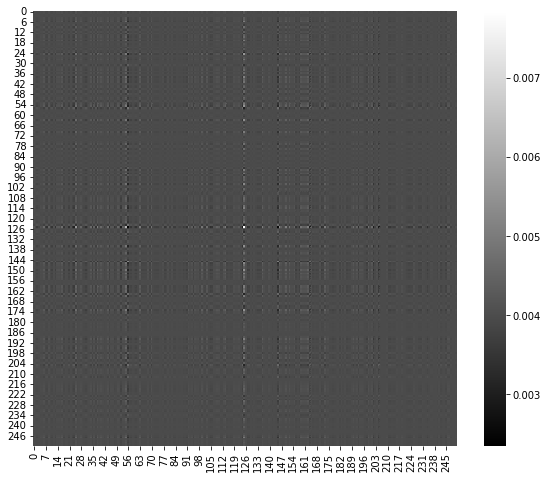

In [ ]:
### Single attention map ###
plt.figure(figsize = (9.5,8))
xx = sb.heatmap(attn_scr_main[100, :, :], cmap='binary_r')

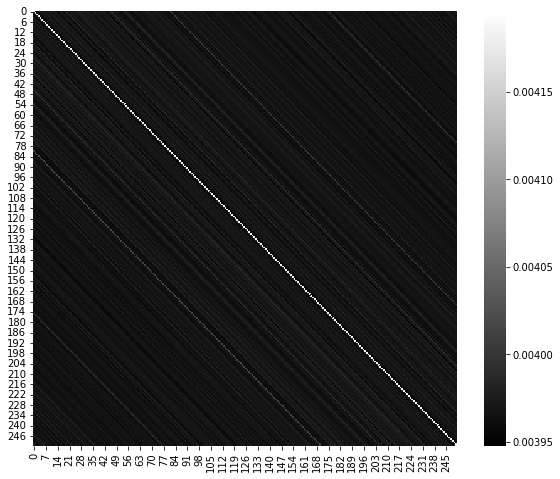

In [ ]:
### Average attention map (main) ###
plt.figure(figsize = (9.5,8))
xx = sb.heatmap(avg_attn_scr_main[:,:], cmap='binary_r')

In [ ]:
### Distance metric calculations ###

dim = attention_scores[:,0,0,0].get_shape().as_list()[0]

## Avg. attention
avg_attn=[]
avg = []

for j in range(0,252):
  for i in range(0,dim):
    avg_attn.insert(i,attention_scores[i,0,0,j])
  avg.insert(j,np.asarray(avg_attn).sum() / dim)
  avg_attn = []

## Temp. attention
temp_attn = np.empty((dim), dtype=object)

for i in range(dim):
    temp_attn[i] = attention_scores[i,0,0,:]

## HELLINGER DISTANCE
dist_t=[]

for i in range(dim):
  p = avg
  q = np.asarray(temp_attn[i])
  dist_t.insert(i,hellinger(p,q))

In [ ]:
returnhistory = pd.DataFrame(df_train['Close'][:dim], columns = ['Close'])
dist_t = pd.DataFrame(dist_t, columns = ['dist_t'])
returnhistory['dist_t'] = dist_t.dist_t.values

In [ ]:
full_list = pd.DataFrame(list(zip(returnhistory['Close'], returnhistory['dist_t'])),
                         columns = ['close', 'dist_t'])
display(HTML(full_list.to_html()))